In [1]:
import torch
import torch.optim as optim
import tqdm.notebook as tqdm
import matplotlib
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.optim.lr_scheduler import StepLR

import copy
import os
import sys
sys.path.append('/Users/Matt/projects/gmmvae/')

import gmmvae

## Data preparation.

In [2]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST('../data', train=True, download=True,
                               transform=transform)
test_dataset = datasets.MNIST('../data', train=False,
                              transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

## Classifier training.

In [3]:
def train_cls(model, train_loader, optimiser, epoch):
    model.train()
    batch_iter = tqdm.tqdm(enumerate(train_loader), desc='Batch')
    for batch_idx, (x, y) in batch_iter:
        optimiser.zero_grad()
        loss, _ = model.nll(x, y)
        loss.backward()
        optimiser.step()
        
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(x), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def test_cls(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for x, y in test_loader:
            loss, output = model.nll(x, y)
            test_loss += loss.item()
            
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(y.view_as(pred)).sum().item()
            
    test_loss /= len(test_loader.dataset)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [4]:
cls = gmmvae.classifiers.MNISTClassificationNet()
cls_optimiser = optim.Adadelta(cls.parameters(), lr=1.0)
cls_scheduler = StepLR(cls_optimiser, step_size=1, gamma=0.7)

In [5]:
for epoch in range(1, 14+1):
    train_cls(cls, train_loader, cls_optimiser, epoch)
    test_cls(cls, test_loader)
    cls_scheduler.step()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.309496
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.606482
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.107956
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.962261
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.811723
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.593819
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.543833
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.463494
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.552771
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.444807
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.257075
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.267323
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.409240
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.221439
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.286455
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.291110
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.397856
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.099397
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.129850
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.113927
Train Epoch: 1 [12800/60000 (

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.065034
Train Epoch: 2 [640/60000 (1%)]	Loss: 0.062250
Train Epoch: 2 [1280/60000 (2%)]	Loss: 0.099638
Train Epoch: 2 [1920/60000 (3%)]	Loss: 0.103152
Train Epoch: 2 [2560/60000 (4%)]	Loss: 0.075521
Train Epoch: 2 [3200/60000 (5%)]	Loss: 0.047184
Train Epoch: 2 [3840/60000 (6%)]	Loss: 0.035846
Train Epoch: 2 [4480/60000 (7%)]	Loss: 0.017459
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.024860
Train Epoch: 2 [5760/60000 (10%)]	Loss: 0.104178
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.068039
Train Epoch: 2 [7040/60000 (12%)]	Loss: 0.034276
Train Epoch: 2 [7680/60000 (13%)]	Loss: 0.074447
Train Epoch: 2 [8320/60000 (14%)]	Loss: 0.103945
Train Epoch: 2 [8960/60000 (15%)]	Loss: 0.024973
Train Epoch: 2 [9600/60000 (16%)]	Loss: 0.058262
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.061862
Train Epoch: 2 [10880/60000 (18%)]	Loss: 0.062970
Train Epoch: 2 [11520/60000 (19%)]	Loss: 0.035082
Train Epoch: 2 [12160/60000 (20%)]	Loss: 0.074082
Train Epoch: 2 [12800/60000 (

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.269967
Train Epoch: 3 [640/60000 (1%)]	Loss: 0.111790
Train Epoch: 3 [1280/60000 (2%)]	Loss: 0.065425
Train Epoch: 3 [1920/60000 (3%)]	Loss: 0.005503
Train Epoch: 3 [2560/60000 (4%)]	Loss: 0.051872
Train Epoch: 3 [3200/60000 (5%)]	Loss: 0.009306
Train Epoch: 3 [3840/60000 (6%)]	Loss: 0.035087
Train Epoch: 3 [4480/60000 (7%)]	Loss: 0.019648
Train Epoch: 3 [5120/60000 (9%)]	Loss: 0.009135
Train Epoch: 3 [5760/60000 (10%)]	Loss: 0.080477
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.025160
Train Epoch: 3 [7040/60000 (12%)]	Loss: 0.034833
Train Epoch: 3 [7680/60000 (13%)]	Loss: 0.035485
Train Epoch: 3 [8320/60000 (14%)]	Loss: 0.008564
Train Epoch: 3 [8960/60000 (15%)]	Loss: 0.111714
Train Epoch: 3 [9600/60000 (16%)]	Loss: 0.051202
Train Epoch: 3 [10240/60000 (17%)]	Loss: 0.034589
Train Epoch: 3 [10880/60000 (18%)]	Loss: 0.029519
Train Epoch: 3 [11520/60000 (19%)]	Loss: 0.031997
Train Epoch: 3 [12160/60000 (20%)]	Loss: 0.030380
Train Epoch: 3 [12800/60000 (

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.098081
Train Epoch: 4 [640/60000 (1%)]	Loss: 0.017483
Train Epoch: 4 [1280/60000 (2%)]	Loss: 0.060619
Train Epoch: 4 [1920/60000 (3%)]	Loss: 0.026621
Train Epoch: 4 [2560/60000 (4%)]	Loss: 0.038397
Train Epoch: 4 [3200/60000 (5%)]	Loss: 0.103586
Train Epoch: 4 [3840/60000 (6%)]	Loss: 0.028525
Train Epoch: 4 [4480/60000 (7%)]	Loss: 0.024267
Train Epoch: 4 [5120/60000 (9%)]	Loss: 0.031119
Train Epoch: 4 [5760/60000 (10%)]	Loss: 0.062257
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.018101
Train Epoch: 4 [7040/60000 (12%)]	Loss: 0.015263
Train Epoch: 4 [7680/60000 (13%)]	Loss: 0.004231
Train Epoch: 4 [8320/60000 (14%)]	Loss: 0.065711
Train Epoch: 4 [8960/60000 (15%)]	Loss: 0.038669
Train Epoch: 4 [9600/60000 (16%)]	Loss: 0.059092
Train Epoch: 4 [10240/60000 (17%)]	Loss: 0.059304
Train Epoch: 4 [10880/60000 (18%)]	Loss: 0.008492
Train Epoch: 4 [11520/60000 (19%)]	Loss: 0.048565
Train Epoch: 4 [12160/60000 (20%)]	Loss: 0.123823
Train Epoch: 4 [12800/60000 (

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.004743
Train Epoch: 5 [640/60000 (1%)]	Loss: 0.015343
Train Epoch: 5 [1280/60000 (2%)]	Loss: 0.007986
Train Epoch: 5 [1920/60000 (3%)]	Loss: 0.004847
Train Epoch: 5 [2560/60000 (4%)]	Loss: 0.007388
Train Epoch: 5 [3200/60000 (5%)]	Loss: 0.017835
Train Epoch: 5 [3840/60000 (6%)]	Loss: 0.053221
Train Epoch: 5 [4480/60000 (7%)]	Loss: 0.023943
Train Epoch: 5 [5120/60000 (9%)]	Loss: 0.044509
Train Epoch: 5 [5760/60000 (10%)]	Loss: 0.067111
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.005286
Train Epoch: 5 [7040/60000 (12%)]	Loss: 0.058223
Train Epoch: 5 [7680/60000 (13%)]	Loss: 0.020764
Train Epoch: 5 [8320/60000 (14%)]	Loss: 0.036975
Train Epoch: 5 [8960/60000 (15%)]	Loss: 0.025604
Train Epoch: 5 [9600/60000 (16%)]	Loss: 0.008356
Train Epoch: 5 [10240/60000 (17%)]	Loss: 0.017369
Train Epoch: 5 [10880/60000 (18%)]	Loss: 0.008295
Train Epoch: 5 [11520/60000 (19%)]	Loss: 0.076773
Train Epoch: 5 [12160/60000 (20%)]	Loss: 0.084704
Train Epoch: 5 [12800/60000 (

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.023667
Train Epoch: 6 [640/60000 (1%)]	Loss: 0.016624
Train Epoch: 6 [1280/60000 (2%)]	Loss: 0.005411
Train Epoch: 6 [1920/60000 (3%)]	Loss: 0.045779
Train Epoch: 6 [2560/60000 (4%)]	Loss: 0.056719
Train Epoch: 6 [3200/60000 (5%)]	Loss: 0.052679
Train Epoch: 6 [3840/60000 (6%)]	Loss: 0.041910
Train Epoch: 6 [4480/60000 (7%)]	Loss: 0.010121
Train Epoch: 6 [5120/60000 (9%)]	Loss: 0.028060
Train Epoch: 6 [5760/60000 (10%)]	Loss: 0.045503
Train Epoch: 6 [6400/60000 (11%)]	Loss: 0.020394
Train Epoch: 6 [7040/60000 (12%)]	Loss: 0.035661
Train Epoch: 6 [7680/60000 (13%)]	Loss: 0.009660
Train Epoch: 6 [8320/60000 (14%)]	Loss: 0.101157
Train Epoch: 6 [8960/60000 (15%)]	Loss: 0.015483
Train Epoch: 6 [9600/60000 (16%)]	Loss: 0.072215
Train Epoch: 6 [10240/60000 (17%)]	Loss: 0.058402
Train Epoch: 6 [10880/60000 (18%)]	Loss: 0.014196
Train Epoch: 6 [11520/60000 (19%)]	Loss: 0.058439
Train Epoch: 6 [12160/60000 (20%)]	Loss: 0.010293
Train Epoch: 6 [12800/60000 (

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.016295
Train Epoch: 7 [640/60000 (1%)]	Loss: 0.039042
Train Epoch: 7 [1280/60000 (2%)]	Loss: 0.032329
Train Epoch: 7 [1920/60000 (3%)]	Loss: 0.011704
Train Epoch: 7 [2560/60000 (4%)]	Loss: 0.025540
Train Epoch: 7 [3200/60000 (5%)]	Loss: 0.054032
Train Epoch: 7 [3840/60000 (6%)]	Loss: 0.044439
Train Epoch: 7 [4480/60000 (7%)]	Loss: 0.047988
Train Epoch: 7 [5120/60000 (9%)]	Loss: 0.040513
Train Epoch: 7 [5760/60000 (10%)]	Loss: 0.007299
Train Epoch: 7 [6400/60000 (11%)]	Loss: 0.007621
Train Epoch: 7 [7040/60000 (12%)]	Loss: 0.069249
Train Epoch: 7 [7680/60000 (13%)]	Loss: 0.103517
Train Epoch: 7 [8320/60000 (14%)]	Loss: 0.003872
Train Epoch: 7 [8960/60000 (15%)]	Loss: 0.041636
Train Epoch: 7 [9600/60000 (16%)]	Loss: 0.002027
Train Epoch: 7 [10240/60000 (17%)]	Loss: 0.050538
Train Epoch: 7 [10880/60000 (18%)]	Loss: 0.035069
Train Epoch: 7 [11520/60000 (19%)]	Loss: 0.052288
Train Epoch: 7 [12160/60000 (20%)]	Loss: 0.011047
Train Epoch: 7 [12800/60000 (

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.013647
Train Epoch: 8 [640/60000 (1%)]	Loss: 0.006364
Train Epoch: 8 [1280/60000 (2%)]	Loss: 0.017547
Train Epoch: 8 [1920/60000 (3%)]	Loss: 0.018201
Train Epoch: 8 [2560/60000 (4%)]	Loss: 0.017947
Train Epoch: 8 [3200/60000 (5%)]	Loss: 0.008013
Train Epoch: 8 [3840/60000 (6%)]	Loss: 0.016427
Train Epoch: 8 [4480/60000 (7%)]	Loss: 0.051102
Train Epoch: 8 [5120/60000 (9%)]	Loss: 0.001356
Train Epoch: 8 [5760/60000 (10%)]	Loss: 0.051762
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.106957
Train Epoch: 8 [7040/60000 (12%)]	Loss: 0.007112
Train Epoch: 8 [7680/60000 (13%)]	Loss: 0.031030
Train Epoch: 8 [8320/60000 (14%)]	Loss: 0.005350
Train Epoch: 8 [8960/60000 (15%)]	Loss: 0.024272
Train Epoch: 8 [9600/60000 (16%)]	Loss: 0.083961
Train Epoch: 8 [10240/60000 (17%)]	Loss: 0.001874
Train Epoch: 8 [10880/60000 (18%)]	Loss: 0.011491
Train Epoch: 8 [11520/60000 (19%)]	Loss: 0.002404
Train Epoch: 8 [12160/60000 (20%)]	Loss: 0.071514
Train Epoch: 8 [12800/60000 (

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.002470
Train Epoch: 9 [640/60000 (1%)]	Loss: 0.005292
Train Epoch: 9 [1280/60000 (2%)]	Loss: 0.014634
Train Epoch: 9 [1920/60000 (3%)]	Loss: 0.150852
Train Epoch: 9 [2560/60000 (4%)]	Loss: 0.077718
Train Epoch: 9 [3200/60000 (5%)]	Loss: 0.030485
Train Epoch: 9 [3840/60000 (6%)]	Loss: 0.046146
Train Epoch: 9 [4480/60000 (7%)]	Loss: 0.014697
Train Epoch: 9 [5120/60000 (9%)]	Loss: 0.010001
Train Epoch: 9 [5760/60000 (10%)]	Loss: 0.015122
Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.123857
Train Epoch: 9 [7040/60000 (12%)]	Loss: 0.023385
Train Epoch: 9 [7680/60000 (13%)]	Loss: 0.098327
Train Epoch: 9 [8320/60000 (14%)]	Loss: 0.025386
Train Epoch: 9 [8960/60000 (15%)]	Loss: 0.003201
Train Epoch: 9 [9600/60000 (16%)]	Loss: 0.011837
Train Epoch: 9 [10240/60000 (17%)]	Loss: 0.011419
Train Epoch: 9 [10880/60000 (18%)]	Loss: 0.008476
Train Epoch: 9 [11520/60000 (19%)]	Loss: 0.009394
Train Epoch: 9 [12160/60000 (20%)]	Loss: 0.021799
Train Epoch: 9 [12800/60000 (

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.061590
Train Epoch: 10 [640/60000 (1%)]	Loss: 0.013940
Train Epoch: 10 [1280/60000 (2%)]	Loss: 0.001369
Train Epoch: 10 [1920/60000 (3%)]	Loss: 0.001290
Train Epoch: 10 [2560/60000 (4%)]	Loss: 0.047459
Train Epoch: 10 [3200/60000 (5%)]	Loss: 0.045382
Train Epoch: 10 [3840/60000 (6%)]	Loss: 0.021474
Train Epoch: 10 [4480/60000 (7%)]	Loss: 0.015565
Train Epoch: 10 [5120/60000 (9%)]	Loss: 0.005314
Train Epoch: 10 [5760/60000 (10%)]	Loss: 0.001086
Train Epoch: 10 [6400/60000 (11%)]	Loss: 0.017787
Train Epoch: 10 [7040/60000 (12%)]	Loss: 0.001825
Train Epoch: 10 [7680/60000 (13%)]	Loss: 0.010985
Train Epoch: 10 [8320/60000 (14%)]	Loss: 0.014290
Train Epoch: 10 [8960/60000 (15%)]	Loss: 0.003463
Train Epoch: 10 [9600/60000 (16%)]	Loss: 0.064125
Train Epoch: 10 [10240/60000 (17%)]	Loss: 0.102215
Train Epoch: 10 [10880/60000 (18%)]	Loss: 0.079056
Train Epoch: 10 [11520/60000 (19%)]	Loss: 0.026394
Train Epoch: 10 [12160/60000 (20%)]	Loss: 0.004918
Train Epo

Train Epoch: 11 [0/60000 (0%)]	Loss: 0.115399
Train Epoch: 11 [640/60000 (1%)]	Loss: 0.032786
Train Epoch: 11 [1280/60000 (2%)]	Loss: 0.059774
Train Epoch: 11 [1920/60000 (3%)]	Loss: 0.003542
Train Epoch: 11 [2560/60000 (4%)]	Loss: 0.004226
Train Epoch: 11 [3200/60000 (5%)]	Loss: 0.046468
Train Epoch: 11 [3840/60000 (6%)]	Loss: 0.007178
Train Epoch: 11 [4480/60000 (7%)]	Loss: 0.001456
Train Epoch: 11 [5120/60000 (9%)]	Loss: 0.011982
Train Epoch: 11 [5760/60000 (10%)]	Loss: 0.002335
Train Epoch: 11 [6400/60000 (11%)]	Loss: 0.013238
Train Epoch: 11 [7040/60000 (12%)]	Loss: 0.007332
Train Epoch: 11 [7680/60000 (13%)]	Loss: 0.009680
Train Epoch: 11 [8320/60000 (14%)]	Loss: 0.002187
Train Epoch: 11 [8960/60000 (15%)]	Loss: 0.046914
Train Epoch: 11 [9600/60000 (16%)]	Loss: 0.060655
Train Epoch: 11 [10240/60000 (17%)]	Loss: 0.005229
Train Epoch: 11 [10880/60000 (18%)]	Loss: 0.009679
Train Epoch: 11 [11520/60000 (19%)]	Loss: 0.010354
Train Epoch: 11 [12160/60000 (20%)]	Loss: 0.003011
Train Epo

Train Epoch: 12 [0/60000 (0%)]	Loss: 0.012873
Train Epoch: 12 [640/60000 (1%)]	Loss: 0.019830
Train Epoch: 12 [1280/60000 (2%)]	Loss: 0.035760
Train Epoch: 12 [1920/60000 (3%)]	Loss: 0.086682
Train Epoch: 12 [2560/60000 (4%)]	Loss: 0.011460
Train Epoch: 12 [3200/60000 (5%)]	Loss: 0.002455
Train Epoch: 12 [3840/60000 (6%)]	Loss: 0.016309
Train Epoch: 12 [4480/60000 (7%)]	Loss: 0.002756
Train Epoch: 12 [5120/60000 (9%)]	Loss: 0.054089
Train Epoch: 12 [5760/60000 (10%)]	Loss: 0.063024
Train Epoch: 12 [6400/60000 (11%)]	Loss: 0.003878
Train Epoch: 12 [7040/60000 (12%)]	Loss: 0.118521
Train Epoch: 12 [7680/60000 (13%)]	Loss: 0.014553
Train Epoch: 12 [8320/60000 (14%)]	Loss: 0.016292
Train Epoch: 12 [8960/60000 (15%)]	Loss: 0.104498
Train Epoch: 12 [9600/60000 (16%)]	Loss: 0.016546
Train Epoch: 12 [10240/60000 (17%)]	Loss: 0.011559
Train Epoch: 12 [10880/60000 (18%)]	Loss: 0.014498
Train Epoch: 12 [11520/60000 (19%)]	Loss: 0.028536
Train Epoch: 12 [12160/60000 (20%)]	Loss: 0.000788
Train Epo

Train Epoch: 13 [0/60000 (0%)]	Loss: 0.005006
Train Epoch: 13 [640/60000 (1%)]	Loss: 0.013916
Train Epoch: 13 [1280/60000 (2%)]	Loss: 0.015623
Train Epoch: 13 [1920/60000 (3%)]	Loss: 0.000755
Train Epoch: 13 [2560/60000 (4%)]	Loss: 0.029088
Train Epoch: 13 [3200/60000 (5%)]	Loss: 0.012207
Train Epoch: 13 [3840/60000 (6%)]	Loss: 0.013331
Train Epoch: 13 [4480/60000 (7%)]	Loss: 0.070425
Train Epoch: 13 [5120/60000 (9%)]	Loss: 0.051822
Train Epoch: 13 [5760/60000 (10%)]	Loss: 0.018233
Train Epoch: 13 [6400/60000 (11%)]	Loss: 0.006146
Train Epoch: 13 [7040/60000 (12%)]	Loss: 0.040331
Train Epoch: 13 [7680/60000 (13%)]	Loss: 0.019064
Train Epoch: 13 [8320/60000 (14%)]	Loss: 0.001120
Train Epoch: 13 [8960/60000 (15%)]	Loss: 0.011830
Train Epoch: 13 [9600/60000 (16%)]	Loss: 0.162409
Train Epoch: 13 [10240/60000 (17%)]	Loss: 0.005742
Train Epoch: 13 [10880/60000 (18%)]	Loss: 0.003270
Train Epoch: 13 [11520/60000 (19%)]	Loss: 0.011600
Train Epoch: 13 [12160/60000 (20%)]	Loss: 0.008488
Train Epo

KeyboardInterrupt: 

## Set GMMVAE datasets. 

In [10]:
pred_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=False)
cls_output = torch.zeros(len(train_dataset), 10)
with torch.no_grad():
    for batch_idx, (x, y) in enumerate(pred_loader):
        cls_output[batch_idx*64:(batch_idx+1)*64] = cls(x).detach().exp()

In [11]:
class GMMVAEDataset(torch.utils.data.Dataset):
    def __init__(self, x, y, cls_output):
        self.x = x
        self.y = y
        self.cls_output = cls_output
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        return self.x[idx, ...], self.cls_output[idx]
    
gmmvae_dataset = GMMVAEDataset(train_dataset.data, train_dataset.targets, cls_output)
gmmvae_loader = torch.utils.data.DataLoader(gmmvae_dataset, batch_size=64)

In [12]:
def train_gmmvae(model, loader, optimiser, epoch):
    model.train()
    train_loss = 0
    batch_iter = tqdm.tqdm(enumerate(loader), desc='Batch')
    
    for batch_idx, (x, pi) in batch_iter:
        optimiser.zero_grad() 
        if isinstance(model, gmmvae.models.GMMVAEFixedCls):
            x = x.unsqueeze(1).float() / 255
            loss = -model.elbo(x, pi, num_samples=1)
        else:
            x = x.view(-1, 784).float() / 255
            loss = -model.elbo(x, pi, num_samples=1)
        
        loss.backward()
        
        optimiser.step()
        
        train_loss += loss.item()        
        batch_iter.set_postfix(loss=loss.item())
            
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(loader.dataset)))

In [13]:
z_dim = 2
x_dim = 784

gmmvae_encoder = gmmvae.networks.LinearGaussian(x_dim, z_dim, [512, 256], min_sigma=1e-3)
gmmvaecls_encoder = gmmvae.networks.LinearGaussianIndexed(x_dim, z_dim, 10, [512, 256], min_sigma=1e-3)
loglikelihood = gmmvae.loglikelihoods.NNBernoulli(z_dim, x_dim, [256, 512])

gmmvae_cls = copy.deepcopy(cls)
for param in gmmvae_cls.parameters():
    param.requires_grad = False

gmmvae_model = gmmvae.models.GMMVAE(
    copy.deepcopy(loglikelihood), gmmvae_encoder, z_dim, 10)
gmmvaecls_model = gmmvae.models.GMMVAEFixedCls(
    copy.deepcopy(loglikelihood), gmmvae_cls, gmmvaecls_encoder,  z_dim, 10)

## GMMVAE training.

In [14]:
gmmvae_optimiser = optim.Adam(gmmvae_model.parameters())
for epoch in range(1, 14+1):
    train_gmmvae(gmmvae_model, gmmvae_loader, gmmvae_optimiser, epoch)


====> Epoch: 1 Average loss: 2.8249



====> Epoch: 2 Average loss: 2.5098


KeyboardInterrupt: 

In [ ]:
gmmvaecls_optimiser = optim.Adam(gmmvaecls_model.parameters())
for epoch in range(1, 14+1):
    train_gmmvae(gmmvaecls_model, gmmvae_loader, gmmvaecls_optimiser, epoch)

## Sample model.

In [20]:
if not os.path.exists('./samples'):
    os.makedirs('./samples')

with torch.no_grad():            
    sample = gmmvae_model.sample(num_samples=100)
    
    filename = './samples/gmmvae_sample'
    
    if os.path.exists(filename + '.png'):
        i = 1
        while os.path.exists(filename + '_' + str(i) + '.png'):
            i += 1
            
        filename = filename + '_' + str(i) + '.png'
        
    else:
        filename = filename + '.png'
    
    save_image(sample.view(100, 1, 28, 28), filename)

## Visualise clustering of latent space.

In [244]:
from matplotlib.patches import Ellipse, Rectangle

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes.
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmmvae(gmmvae, x, y, pi, ax=None):
    ax = ax or plt.gca()
    z = gmmvae.encoder(x, y)[0].detach()
    h = - (pi * (pi.log()) / np.log(2)).sum(1)
    
    colours = plt.rcParams['axes.prop_cycle'].by_key()['color']
    c = [colours[y_] for y_ in y]
#     s = 50 * h / h.max()
    s = 20
    ax.scatter(z[:, 0], z[:, 1], c=c, alpha=.75, marker='x', s=s)
    ax.axis('equal')
    
    for mu, logsigma, colour in zip(gmmvae.pz_y_mu, gmmvae.pz_y_logsigma, colours):
        mu = mu.detach().numpy()
        cov = logsigma.exp().diag_embed().detach().numpy()
        draw_ellipse(mu, cov, alpha=.1, color=colour)


def plot_gmmvaecls(model, x, y, pi, ax=None):
    ax = ax or plt.gca()
    z = gmmvae.encoder(x, y)[0].detach()
    h = - (pi * (pi.log()) / np.log(2)).sum(1)
    
    colours = plt.rcParams['axes.prop_cycle'].by_key()['color']
    c = [colours[y_] for y_ in y]
#     s = 50 * h / h.max()
    s = 20
    ax.scatter(z[:, 0], z[:, 1], c=c, alpha=.75, marker='x', s=s)
    ax.axis('equal')

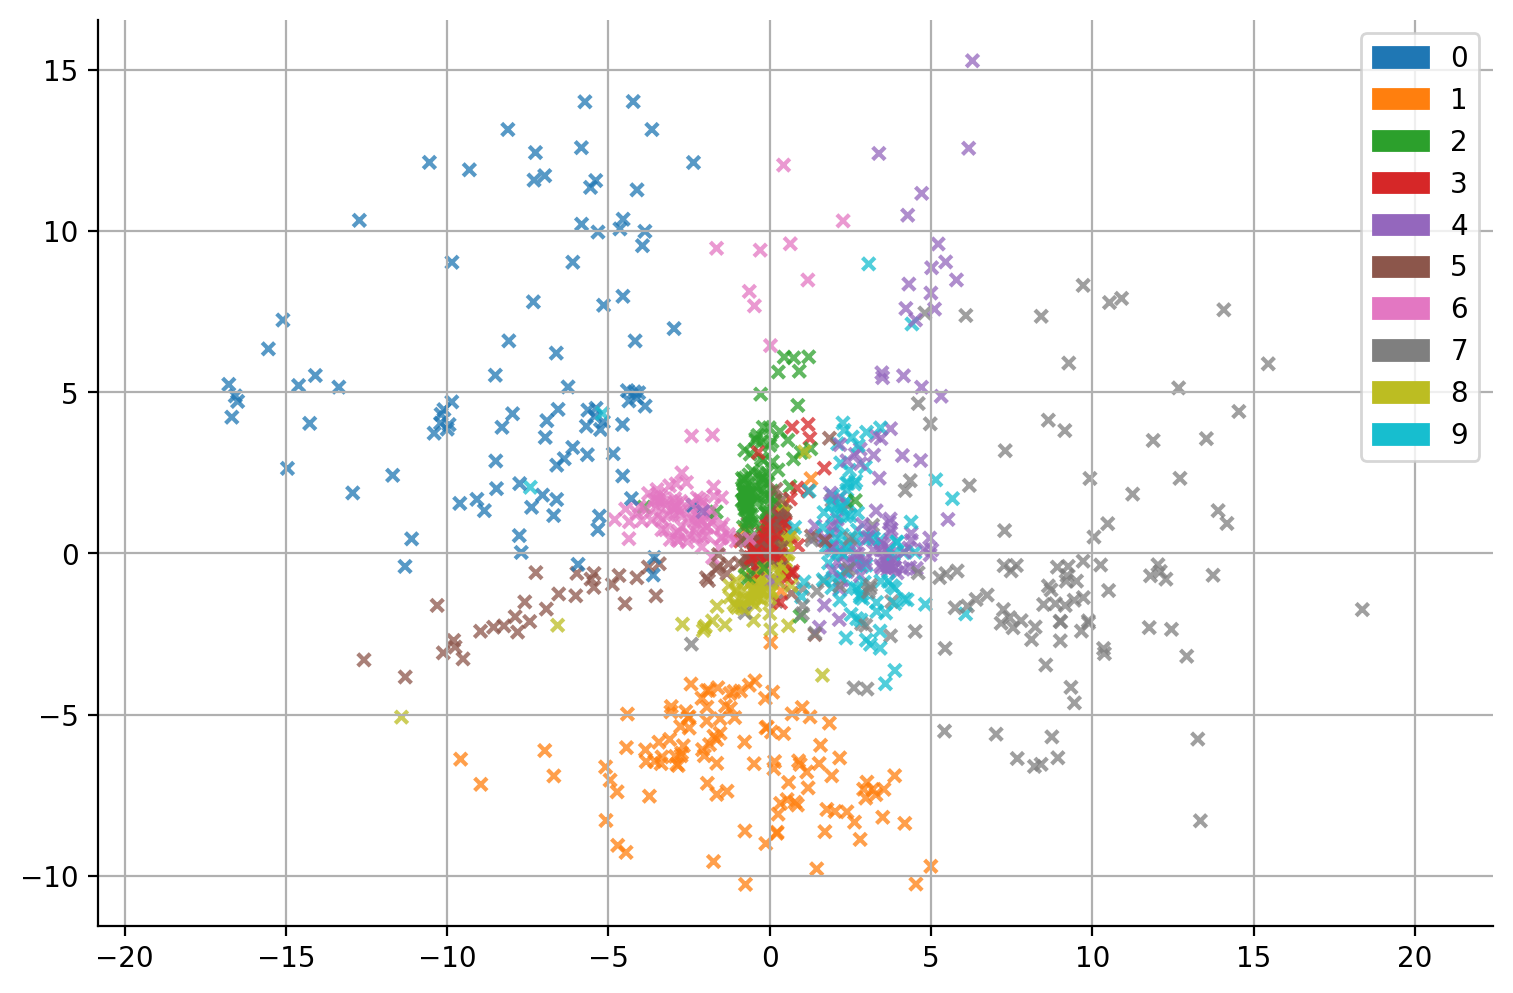

In [245]:
fig = plt.figure(figsize=(9, 6), dpi=200)

x = gmmvae_dataset.x[:1000].view(-1, 784).float() / 255
y = gmmvae_dataset.y[:1000]
pi = gmmvae_dataset.cls_output[:1000]
plot_gmmvae(gmmvaecls_model, x, y, pi)

# Hide the right and top spines.
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Add legend.
colours = plt.rcParams['axes.prop_cycle'].by_key()['color']
custom_patches = [Rectangle((0, 0), 1, 1, color=colours[i]) for i in range(10)]
ax.legend(custom_patches, [str(i) for i in range(10)])

plt.grid(0.25)
plt.show()

In [147]:
import torch
import torch.nn as nn
import numpy as np

from torch.distributions.normal import Normal
from torch.distributions.categorical import Categorical
from torch.distributions.kl import kl_divergence


class GMMVAE(nn.Module):

    def __init__(self, encoder, loglikelihood, z_dim, k):
        super().__init__()

        self.encoder = encoder
        self.loglikelihood = loglikelihood
        self.z_dim = z_dim
        self.k = k

        # Initialise GMM parameters.
        self.pz_y_mu = nn.Parameter(torch.randn((k, z_dim)),
                                    requires_grad=True)
        self.pz_y_logsigma = nn.Parameter(torch.zeros((k, z_dim)),
                                          requires_grad=True)

    def qz(self, x):
        qz_mu, qz_sigma = self.encoder(x)
        qz = Normal(qz_mu, qz_sigma)

        return qz

    def py_z(self, z, pi):
        # Compute the marginal likelihood, p(z) = \sum_k p(z|y)p(y).
        pzy = torch.zeros_like(pi)
        for k in range(self.k):
            pz_y = Normal(self.pz_y_mu[k, :], self.pz_y_logsigma[k, :].exp())
            pzy[:, k] = pz_y.log_prob(z).sum(1)
            pzy[:, k] += pi[:, k].log()

        pz = torch.logsumexp(pzy, dim=1)

        # Compute the posterior p(y|z) = p(z, y) / p(z)
        py_z = pzy - pz.unsqueeze(1)
        py_z = Categorical(py_z.exp())

        return py_z

    def elbo(self, x, pi, num_samples=1):
        """Monte Carlo estimate of the evidence lower bound."""
        qz = self.qz(x)

        # z_samples is shape (num_samples, batch, z_dim).
        z_samples = qz.rsample((num_samples,))

        log_px_z = 0
        kl_y = 0
        kl_z = 0
        for z in z_samples:
            log_px_z += self.loglikelihood(z, x).sum()

            py_z = self.py_z(z, pi)
            kl_y += kl_divergence(py_z, Categorical(pi)).sum()

            for k in range(self.k):
                pz_y = Normal(self.pz_y_mu[k, :], self.pz_y_logsigma[k, :].exp())

                kl_z_k = py_z.probs[:, k] * kl_divergence(qz, pz_y).sum(1)
                kl_z += kl_z_k.sum()

        log_px_z /= num_samples
        kl_y /= num_samples
        kl_z /= num_samples
        elbo = (log_px_z - kl_y - kl_z) / x.shape[0]

        return elbo

    def sample(self, pi=None, num_samples=1):
        if pi is None:
            pi = torch.ones(self.k) / self.k

        # Sample p(y).
        py = Categorical(pi)
        y = py.sample((num_samples,))

        # Sample p(z|y).
        pz_y = Normal(self.pz_y_mu[y, :], self.pz_y_logsigma[y, :].exp())
        z = pz_y.sample()

        # Sample p(x|z).
        samples = self.loglikelihood.predict(z)

        return samples

    def predict_x(self, z):
        x = self.loglikelihood.predict(z)

        return x

    def reconstruct_x(self, x):
        z, _ = self.encoder(x)
        x_recon = self.loglikelihood.predict(z)

        return x_recon

In [214]:
class GMMVAE2FixedCls(nn.Module):

    def __init__(self, cls, encoder, loglikelihood, z_dim, k, init_sigma=1.):
        super().__init__()

        self.cls = cls
        self.encoder = encoder
        self.loglikelihood = loglikelihood
        self.z_dim = z_dim
        self.k = k

        # Initialise GMM parameters.
        self.pz_y_mu = nn.Parameter(torch.randn((k, z_dim)) * 0.1,
                                    requires_grad=True)
        self.pz_y_logsigma = nn.Parameter(
            (torch.ones((k, z_dim)) * init_sigma).log(), requires_grad=True)

    def qy(self, x, cls_output=None):
        if cls_output is None:
            cls_output = self.cls(x).detach()
            
        qy = Categorical(cls_output.exp())

        return qy

    def qz(self, x, y):
        qz_mu, qz_sigma = self.encoder(x, y)
        qz = Normal(qz_mu, qz_sigma)

        return qz

    def elbo(self, x, cls_output=None, pi=None, num_samples=1):
        """Monte Carlo estimate of the evidence lower bound."""
        qy = self.qy(x, cls_output)
        x = x.flatten(start_dim=1)

        log_px_z = 0
        for _ in range(num_samples):
            y = qy.sample()
            qz = self.qz(x, y)
            z = qz.rsample()
            log_px_z += self.loglikelihood(z, x).sum()

        log_px_z /= num_samples

        if pi is None:
            pi = torch.ones(self.k) / self.k

        py = Categorical(pi)
        kl_y = kl_divergence(qy, py).sum()

        kl_z = 0
        for k in range(self.k):
            pz_y = Normal(self.pz_y_mu[k, :],
                          self.pz_y_logsigma[k, :].exp())
            qz = self.qz(x, torch.ones(x.shape[0]).fill_(k))

            kl_z_k = qy.probs[:, k] * kl_divergence(qz, pz_y).sum(1)
            kl_z += kl_z_k.sum()

        elbo = (log_px_z - kl_y - kl_z) / x.shape[0]

        return elbo

In [239]:
import torch.nn.functional as F

from gmmvae.networks import LinearNN


class LinearGaussianIndexed(nn.Module):

    def __init__(self, in_dim, out_dim, k, hidden_dims=(64, 64), min_sigma=0.,
                 nonlinearity=F.relu):
        super().__init__()

        self.out_dim = out_dim
        self.k = k
        self.min_sigma = min_sigma
        self.networks = nn.ModuleList()
        for _ in range(k):
            self.networks.append(LinearNN(in_dim, 2*out_dim, hidden_dims,
                                          nonlinearity))

    def forward(self, x, y):
        """Returns parameters of a diagonal Gaussian distribution."""
        # Sort into groups.
        output = torch.zeros((x.shape[0], 2*self.out_dim))
        for k in range(self.k):
            idx = torch.where(y == k)[0]
            output[idx, :] = self.networks[k](x[idx, :])

        mu = output[..., :self.out_dim]
        sigma = self.min_sigma + F.softplus(output[..., self.out_dim:])
    
        return mu, sigma